In [56]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [57]:
def funcao_custo(x):
    custo = 2 ** -2 * (x - 0.1 / 0.9) ** 2 * (math.sin(5 * math.pi * x))** 6
    return custo

In [58]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(t, resultados)
    plt.show()

In [67]:
def get_vizinhos(solucao):
    vizinhos = []
    vizinhos.append(solucao + 0.05)
    vizinhos.append(solucao - 0.05)
    return vizinhos

In [68]:
def hill_climbing(funcao_custo):
    solucao = random.random() #inicia solução aleatória entre 0 e 1
    custos = []
    count = 0
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao) #perturbação aleatória* pequena 0.05
        
        atual = funcao_custo(solucao)
        melhor = atual
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo >= melhor:
                custos.append(custo)
                melhor = custo
                solucao = vizinhos[i]
                parar_no_plato += 1 if custo == melhor else 0

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            print('plato' if parar_no_plato == 20 else 'sem melhoria')
            break

    return solucao, custos

sem melhoria
menor custo 0.45684622234128147


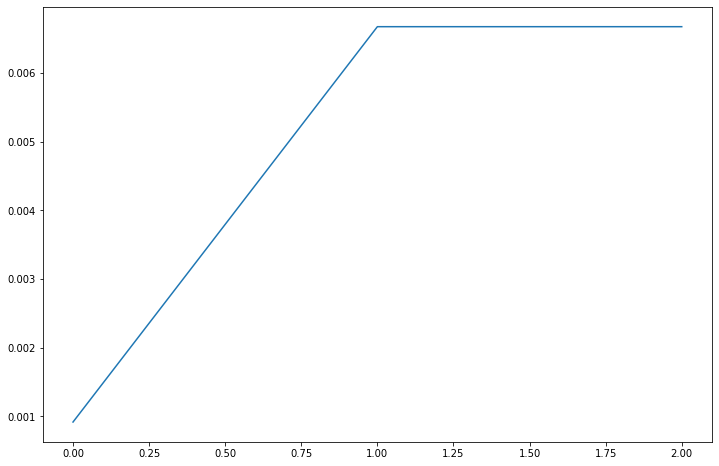

In [81]:
solucao_subida_encosta = hill_climbing(funcao_custo)

print('menor custo', solucao_subida_encosta[0])
plotar_busca(solucao_subida_encosta[1])